# Here I am

Use MobileNetV2

Papers

- [MobileNet arXiv:1704.04861v1](https://arxiv.org/abs/1704.04861)
- [MobileNetV2 arXiv:1801.04381](https://arxiv.org/abs/1801.04381)

Dataset:

- training set: came from imageNet
    - 433 Label (0,1) positive images (human)
    - 674 Label (1,0) negative images (background)
- training set: came from google photo search
    - 256 Label (0,1) positive images (human)
    - 363 Label (1,0) negative images (background)
- training set: came from our photos
    - 73 Label (0,1) positive images (human)
    - 73 Label (1,0) negative images (background)
    
- test set: came from google photo search 
    - 50 Label (0,1) positive images (human)
    - 50 Label (1,0) negative images (background)
- test set: our photoes
    - 100 Label (0,1) positive images (human)
    - 100 Label (1,0) negative images (background)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from imageLoader import ImageLoader
iTrain = ImageLoader(
    "/home/guest/DataSets/someOemos/bag",
    "/home/guest/DataSets/someOemos/man"
)


iTrain2 = ImageLoader(
    "/home/guest/CODE/someOemos/trainSet2/bag",
    "/home/guest/CODE/someOemos/trainSet2/man"
)

iTrain3 = ImageLoader(
    "/home/guest/DataSets/someOemos/googlePhotos/bag",
    "/home/guest/DataSets/someOemos/googlePhotos/man"
)

# test set
iTest = ImageLoader(
    "/home/guest/CODE/someOemos/testSet/bg_square",
    "/home/guest/CODE/someOemos/testSet/man_square"
)

iTest2 = ImageLoader(
    "/home/guest/DataSets/someOemos/googlePhotos/bagtest",
    "/home/guest/DataSets/someOemos/googlePhotos/mantest",
)

## Before Start Take A Look At The DataSet

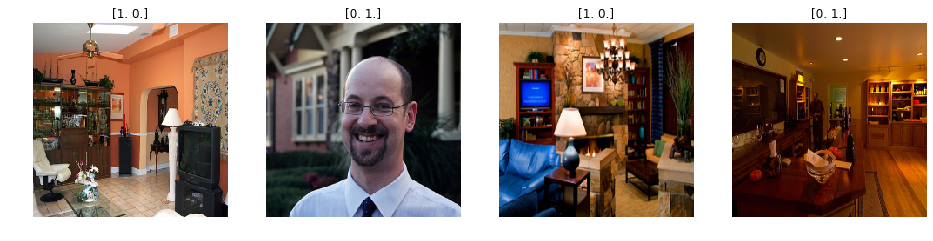

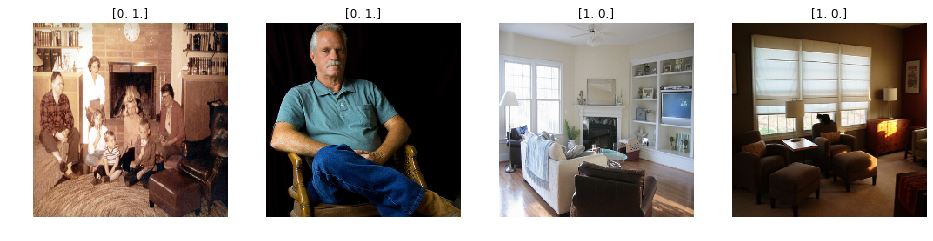

In [3]:
for p, l in iTrain.quick_iteration(diskbatch=4, listbatch=4, limit=1):
    plt.figure(figsize=(16,6))
    for i in range(p.shape[0]):
        plt.subplot(1,4,i+1)
        plt.imshow(p[i])
        plt.axis('off')
        plt.title(str(l[i]))
    plt.show()

## Precision and Recall

In [2]:
def precisionAndRecall(outbag, outman):
    
    pridbag = np.argmax(outbag, axis=1)
    pridman = np.argmax(outman, axis=1)

    TP = np.mean(pridman == 1)
    # act 0 prid 1
    FP = np.mean(pridbag == 1)
    # act 1 prid 0
    FN = np.mean(pridman == 0)
    P = TP / (TP + FP)
    R = TP / (TP + FN)
    print("precision", P)
    print("recall   ", R)
    print("F1       ", 2 * P * R / (P + R))

### Bottleneck

Input: 

1. $h \times w \times k$ $\rightarrow$ $1 \times 1$ conv2d, ReLU6 $\rightarrow$ $h \times w \times (tk) $
2. $h \times w \times tk$ $\rightarrow$ $3 \times 3$ dwise s=s, ReLU6, $\rightarrow$ $\dfrac{h}{s} \times \dfrac{w}{s} \times (tk)$
3. $\dfrac{h}{s} \times \dfrac{w}{s} \times (tk)$ $\rightarrow$ linear $1 \times 1$ conv2d $\rightarrow$ $\dfrac{h}{s} \times \dfrac{w}{s} \times k'$



In [3]:
def bottleneck_stride1(inputs, filters, t, name=None):
    C = filters # NHWC
    with tf.name_scope(name, "bottleneck_stride1"):
        out = tf.layers.conv2d(inputs, t * C, (1,1), strides=1, padding="same")
        out = tf.layers.batch_normalization(out)
        out = tf.nn.leaky_relu(out, 0.2)
        with tf.variable_scope(name, "depthwise_convolution"):
            w = tf.get_variable("filter", shape=[3, 3, t*C, 1], dtype=tf.float32)
            b = tf.get_variable("bias", shape=[t*C])
            out = tf.nn.depthwise_conv2d(out, w, (1,1,1,1), padding="SAME") + b
            out = tf.layers.batch_normalization(out)
            out = tf.nn.leaky_relu(out, 0.2)
        out = tf.layers.conv2d(out, C, (1,1), strides=1, padding="same")
        out = tf.layers.batch_normalization(out)
    if C != inputs.shape[3]:
        inputs = tf.layers.conv2d(inputs, C, (1,1), strides=1, padding="same")
    return out + inputs

def bottleneck_stride2(inputs, filters, t, name=None):
    C = filters # NHWC
    with tf.name_scope(name, "bottleneck_stride2"):
        out = tf.layers.conv2d(inputs, t * C, (1,1), strides=1, padding="same")
        out = tf.layers.batch_normalization(out)
        out = tf.nn.leaky_relu(out, 0.2)
        with tf.variable_scope(name, "depthwise_convolution"):
            w = tf.get_variable("filter", shape=[3, 3, t*C, 1], dtype=tf.float32)
            b = tf.get_variable("bias", shape=[t*C])
            out = tf.nn.depthwise_conv2d(out, w, (1,2,2,1), padding="SAME") + b
            out = tf.layers.batch_normalization(out)
            out = tf.nn.leaky_relu(out, 0.2)
        out = tf.layers.conv2d(out, C, (1,1), strides=1, padding="same")
        out = tf.layers.batch_normalization(out)
    return out

## Network structure


|      Input   |   Operator  | t |   c  | n | s |
|:------------:|:-----------:|:-:|:----:|:-:|:-:|
| $224^2$ × 3  | conv2d      | - | 32   | 1 | 2 |
| $112^2$ × 32 | bottleneck  | 1 | 16   | 1 | 1 |
| $112^2$ × 16 | bottleneck  | 6 | 24   | 2 | 2 |
| $56^2$ × 24  | bottleneck  | 6 | 32   | 3 | 2 |
| $28^2$ × 32  | bottleneck  | 6 | 64   | 4 | 2 |
| $14^2$ × 64  | bottleneck  | 6 | 96   | 3 | 1 |
| $14^2$ × 96  | bottleneck  | 6 | 160  | 3 | 2 |
| $7^2$ × 160  | bottleneck  | 6 | 320  | 1 | 1 |
| $7^2$ × 320  | conv2d 1x1  | - | 1280 | 1 | 1 |
| $7^2$ × 1280 | avgpool 7x7 | - |   -  | 1 | - |
| 1 × 1 × 1280 | conv2d 1x1  | - |   k  | - |   |

In [4]:
mImage = tf.placeholder(tf.float32, shape=[None, 224, 224, 3], name="input_images")
mLabel = tf.placeholder(tf.float32, shape=[None, 2], name="output_labels")

TheLayers = []

In [5]:
# 224 × 3 conv2d - 32 1 2
xLayer = tf.layers.conv2d(mImage, 32, (3,3), strides=2, padding="same")
xLayer = tf.layers.batch_normalization(xLayer)
xLayer = tf.nn.leaky_relu(xLayer, 0.2)
print(xLayer.shape, "112 112 32")
TheLayers.append(xLayer)

# 112 × 32 bottleneck 1 16 1 1
xLayer = bottleneck_stride1(xLayer, 16, 1)
print(xLayer.shape, "112 112 16")
TheLayers.append(xLayer)

# 112 × 16 bottleneck 6 24 2 2
xLayer = bottleneck_stride2(xLayer, 24, 2)
print(xLayer.shape, "54 54 24")
TheLayers.append(xLayer)

# 56 × 24 bottleneck 6 32 3 2
xLayer = bottleneck_stride2(xLayer, 32, 2)
xLayer = bottleneck_stride1(xLayer, 32, 2)
print(xLayer.shape, "28 28 32")
TheLayers.append(xLayer)

#28 × 32 bottleneck 6 64 4 2
xLayer = bottleneck_stride2(xLayer, 64, 2)
xLayer = bottleneck_stride1(xLayer, 64, 2)
print(xLayer.shape, "14 14 64")
TheLayers.append(xLayer)

# 14 × 64 bottleneck 6 96 3 1
xLayer = bottleneck_stride1(xLayer, 64, 2)
print(xLayer.shape, "14 14 64")

# 14 × 96 bottleneck 6 160 3 2
xLayer = bottleneck_stride2(xLayer, 64, 2)
xLayer = bottleneck_stride1(xLayer, 64, 2)
print(xLayer.shape, "7 7 16")

# 7 × 160 bottleneck 6 320 1 1
xLayer = bottleneck_stride1(xLayer, 64, 2)
print(xLayer.shape, "7 7 16")

# aliy change it to 320
# 7 × 320 conv2d 1x1 - 1280 1 1
xLayer = tf.layers.conv2d(xLayer, 32, (5,5), strides=1, padding="valid")
xLayer = tf.layers.batch_normalization(xLayer)
xLayer = tf.nn.leaky_relu(xLayer, 0.2)
print(xLayer.shape, "7 7 160")

# 7 × 1280 avgpool 7x7 - - 1 -
xLayer = tf.layers.conv2d(xLayer, 16, (3,3), 1, padding="valid")
xLayer = tf.layers.batch_normalization(xLayer)
print(xLayer.shape, "1 1 8")
# 1 × 1 × 1280 conv2d 1x1 - k -

(?, 112, 112, 32) 112 112 32
(?, 112, 112, 16) 112 112 16
(?, 56, 56, 24) 54 54 24
(?, 28, 28, 32) 28 28 32
(?, 14, 14, 64) 14 14 64
(?, 14, 14, 64) 14 14 64
(?, 7, 7, 64) 7 7 16
(?, 7, 7, 64) 7 7 16
(?, 3, 3, 32) 7 7 160
(?, 1, 1, 16) 1 1 8


In [6]:
oLogits = tf.layers.flatten(xLayer)
print(oLogits.shape)
oLogits = tf.layers.dense(oLogits, 8)
oLogits = tf.nn.leaky_relu(oLogits, 0.2)
oLogits = tf.layers.dense(oLogits,2)
print(oLogits.shape)

(?, 16)
(?, 2)


## Loss Function And Optimizer

$$
L(y, \hat{y}) = - \sum_i y \log(\sigma(\hat{y}))
$$

$$
\sigma(x) = \dfrac{1}{1 + e^{-x}}
$$

In [7]:
LossFunction = tf.losses.sigmoid_cross_entropy(mLabel, oLogits)

learningRate = tf.train.cosine_decay(1e-4, 1, 4, alpha=0.0)

Optim = tf.train.AdamOptimizer(learning_rate=learningRate).minimize(LossFunction)

## Train

In [8]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [9]:
sess.run(tf.global_variables_initializer())

In [10]:
saver = tf.train.Saver(max_to_keep=5)
CHECK_POINT_PATH = 'savemodel/aliymobienetv2A3.ckpt'

In [11]:
saver.restore(sess, CHECK_POINT_PATH)

INFO:tensorflow:Restoring parameters from savemodel/aliymobienetv2A3.ckpt


## Train On ImageNet Data

In [14]:
for epho, tdata in enumerate(iTrain.disk_iteration_random(batch=200, limit=10)):
    lloss = 0
    for img, lab in iTrain.list_iteration(imgP=tdata[0], imgN=tdata[1], batch=100):
        feed = {
            mImage: img,# + np.random.rand(*img.shape),
            mLabel: lab
        }
        for i in range(5):
            l,_ = sess.run([LossFunction, Optim], feed_dict=feed)
            lloss += l
    print("Epho {:03d} Loss {:8f}".format(epho, lloss))
    saver.save(sess, CHECK_POINT_PATH)

Epho 000 Loss 2.381456
Epho 001 Loss 1.883010
Epho 002 Loss 2.304107
Epho 003 Loss 1.772878
Epho 004 Loss 2.032073
Epho 005 Loss 1.190885
Epho 006 Loss 1.664299
Epho 007 Loss 1.912518
Epho 008 Loss 1.196573
Epho 009 Loss 0.689569


In [16]:
outbag = sess.run(oLogits, feed_dict={mImage: iTrain.load_bag(200)})
outman = sess.run(oLogits, feed_dict={mImage: iTrain.load_man(200)})

precisionAndRecall(outbag, outman)

precision 1.0
recall    0.98
F1        0.98989898989899


## Train On Google Image Search Data

In [12]:
for epho, tdata in enumerate(iTrain3.disk_iteration_random(batch=100, limit=10)):
    lloss = 0
    for img, lab in iTrain3.list_iteration(imgP=tdata[0], imgN=tdata[1], batch=50):
        feed = {
            mImage: img,# + np.random.randn(*img.shape),
            mLabel: lab
        }
        for i in range(5):
            l,_ = sess.run([LossFunction, Optim], feed_dict=feed)
            lloss += l
    print("Epho {:03d} Loss {:8f}".format(epho, lloss))
    saver.save(sess, CHECK_POINT_PATH)   

Epho 000 Loss 4.349655
Epho 001 Loss 3.447696
Epho 002 Loss 2.157598
Epho 003 Loss 1.259161
Epho 004 Loss 1.681948
Epho 005 Loss 1.626523
Epho 006 Loss 1.514305
Epho 007 Loss 0.741465
Epho 008 Loss 0.830820
Epho 009 Loss 0.323525


In [13]:
outbag = sess.run(oLogits, feed_dict={mImage: iTest2.load_bag()})
outman = sess.run(oLogits, feed_dict={mImage: iTest2.load_man()})

precisionAndRecall(outbag, outman)

precision 0.6888888888888889
recall    0.62
F1        0.6526315789473685


## Train On self data

In [18]:
# for epho, tdata in enumerate(iTrain2.disk_iteration_random(batch=10, limit=2)):
#     lloss = 0
#     for img, lab in iTrain2.list_iteration(imgP=tdata[0], imgN=tdata[1], batch=5):
#         feed = {
#             mImage: img.astype(np.float32),
#             mLabel: lab.astype(np.float32)
#         }
#         for i in range(5):
#             l,_ = sess.run([LossFunction, Optim], feed_dict=feed)
#             lloss += l
#     print("Epho {:03d} Loss {:8f}".format(epho, lloss))
#     saver.save(sess, CHECK_POINT_PATH)   

Epho 000 Loss 6.609254
Epho 001 Loss 14.091540


In [15]:
outbag = sess.run(oLogits, feed_dict={mImage: iTest.load_bag(10)})
outman = sess.run(oLogits, feed_dict={mImage: iTest.load_man(10)})

precisionAndRecall(outbag, outman)

precision 0.875
recall    0.7
F1        0.7777777777777777


## Convert To TL Lite

In [16]:
converter = tf.contrib.lite.TFLiteConverter.from_session(sess, [mImage], [oLogits])

INFO:tensorflow:Froze 204 variables.
INFO:tensorflow:Converted 204 variables to const ops.


In [17]:
tflite_model = converter.convert()
open("HereIacMobileNetV2A3.tflite", "wb").write(tflite_model)

717236

## ^_^